In [23]:
import os
import chromadb
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

In [24]:
ROOT = './data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))
HNSW_SPACE = "hnsw:space"

In [25]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + '/' + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + '/' + filename
            files_path.append(filepath)
    return files_path

data_path = f'{ROOT}/train'
files_path = get_files_path(data_path)
files_path

['./data/train/African_crocodile/n01697457_10393.JPEG',
 './data/train/African_crocodile/n01697457_104.JPEG',
 './data/train/African_crocodile/n01697457_1331.JPEG',
 './data/train/African_crocodile/n01697457_14906.JPEG',
 './data/train/African_crocodile/n01697457_18587.JPEG',
 './data/train/African_crocodile/n01697457_260.JPEG',
 './data/train/African_crocodile/n01697457_5586.JPEG',
 './data/train/African_crocodile/n01697457_8136.JPEG',
 './data/train/African_crocodile/n01697457_8331.JPEG',
 './data/train/African_crocodile/n01697457_85.JPEG',
 './data/train/American_egret/n02009912_1358.JPEG',
 './data/train/American_egret/n02009912_13895.JPEG',
 './data/train/American_egret/n02009912_15872.JPEG',
 './data/train/American_egret/n02009912_16896.JPEG',
 './data/train/American_egret/n02009912_26245.JPEG',
 './data/train/American_egret/n02009912_36395.JPEG',
 './data/train/American_egret/n02009912_4403.JPEG',
 './data/train/American_egret/n02009912_5700.JPEG',
 './data/train/American_egret/

In [26]:
def plot_results(image_path, files_path, results):
    query_image = Image.open(image_path).resize((448,448))
    images = [query_image]
    class_name = []
    for id_img in results['ids'][0]:
        id_img = int(id_img.split('_')[-1])
        img_path = files_path[id_img]
        img = Image.open(img_path).resize((448,448))
        images.append(img)
        class_name.append(img_path.split('/')[2])

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Iterate through images and plot them
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        if i == 0:
            ax.set_title(f"Query Image: {image_path.split('/')[2]}")
        else:
            ax.set_title(f"Top {i+1}: {class_name[i-1]}")
        ax.axis('off')  # Hide axes
    # Display the plot
    plt.show()

In [27]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=np.array(image))
    return embedding

In [28]:
def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        image = Image.open(filepath)
        embedding = get_single_image_embedding(image=image)
        embeddings.append(embedding)
    collection.add(
        embeddings=embeddings,
        ids=ids
    )

In [29]:
# Create a Chroma Client
chroma_client = chromadb.Client()
# Create a collection
l2_collection = chroma_client.get_or_create_collection(name="l2_collection",
                                                           metadata={HNSW_SPACE: "l2"})
add_embedding(collection=l2_collection, files_path=files_path)

595it [01:19,  7.52it/s]


In [30]:
def search(image_path, collection, n_results):
    query_image = Image.open(image_path)
    query_embedding = get_single_image_embedding(query_image)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results # how many results to return
    )
    return results

In [31]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
l2_results = search(image_path=test_path, collection=l2_collection, n_results=5)

In [32]:
l2_results

{'ids': [['id_14', 'id_19', 'id_16', 'id_18', 'id_11']],
 'distances': [[0.40494656562805176,
   0.41377538442611694,
   0.5006764531135559,
   0.5080233812332153,
   0.5198467969894409]],
 'metadatas': [[None, None, None, None, None]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

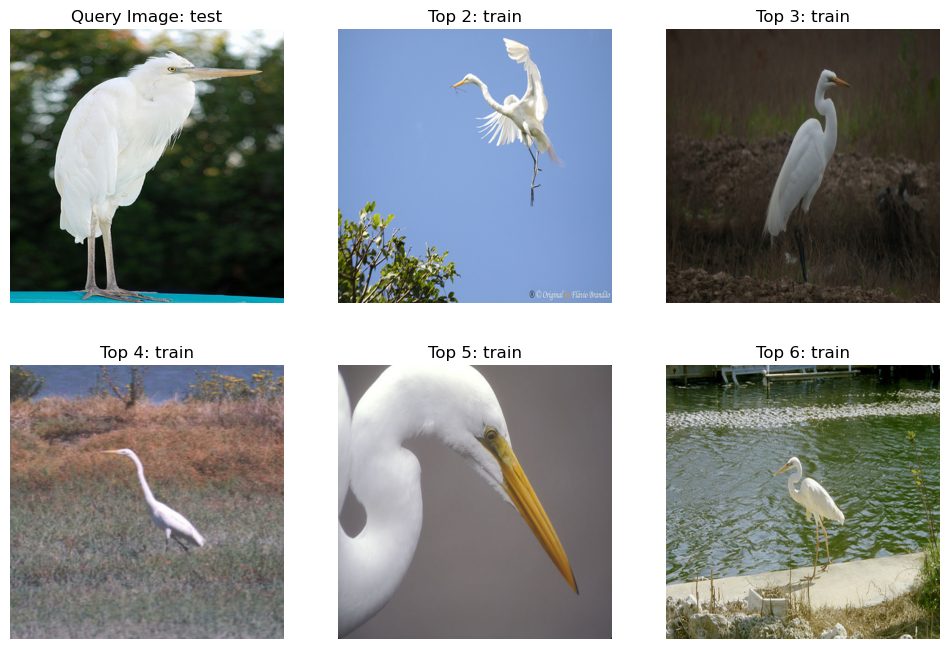

In [33]:
plot_results(test_path, files_path, l2_results)

In [34]:
# Create a collection
cosine_collection = chroma_client.get_or_create_collection(name="Cosine_collection", metadata={HNSW_SPACE: "cosine"})
add_embedding(collection=cosine_collection, files_path=files_path)

595it [01:05,  9.13it/s]


In [35]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
cosine_results = search(image_path=test_path, collection=cosine_collection, n_results=5)

In [36]:
cosine_results

{'ids': [['id_14', 'id_19', 'id_16', 'id_18', 'id_11']],
 'distances': [[0.20247328281402588,
   0.20688754320144653,
   0.2503383755683899,
   0.25401175022125244,
   0.25992321968078613]],
 'metadatas': [[None, None, None, None, None]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

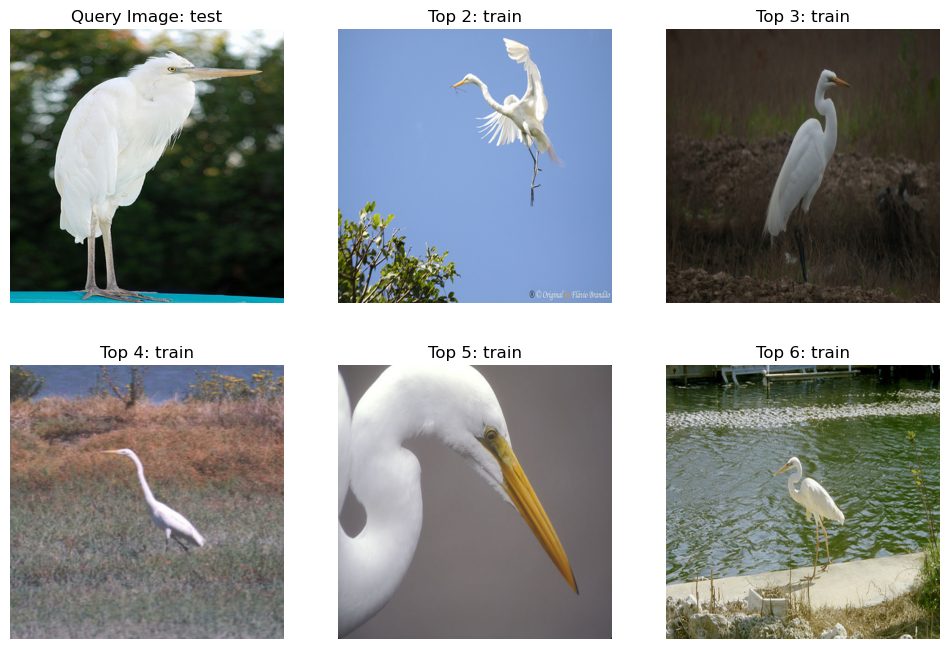

In [37]:
plot_results(image_path=test_path, files_path=files_path, results=cosine_results)